In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following code utilizes data from from the University Medical Centre, Institute of Oncology, Ljubljana, Yugoslavia [1].

In [2]:
import pandas as pd
from sklearn import tree
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


%matplotlib inline

cancer = pd.read_csv('/content/drive/MyDrive/Datasets/breast-cancer-data.csv') #avoiding UCI dataset issues
cancer = cancer.map(lambda x: str(x).replace("'", "") if isinstance(x, str) else x) #clearing the ' in every entry in this csv file
cancer.head(150)

,age,menopause,tumer-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate,class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events
...,...,...,...,...,...,...,...,...,...,...
145,50-59,premeno,10-14,0-2,no,3,left,left_low,no,no-recurrence-events
146,30-39,premeno,30-34,9-11,no,2,right,left_up,yes,recurrence-events
147,60-69,ge40,10-14,0-2,no,1,left,left_low,no,no-recurrence-events
148,40-49,premeno,40-44,0-2,no,2,right,left_low,no,no-recurrence-events


### Exploratory data analysis

In [3]:
#Finding the mode of each column as it is relevant for later.
for column in cancer:
  print(cancer[column].mode())


0    50-59
Name: age, dtype: object
0    premeno
Name: menopause, dtype: object
0    30-34
Name: tumer-size, dtype: object
0    0-2
Name: inv-nodes, dtype: object
0    no
Name: node-caps, dtype: object
0    2
Name: deg-malig, dtype: object
0    left
Name: breast, dtype: object
0    left_low
Name: breast-quad, dtype: object
0    no
Name: irradiate, dtype: object
0    no-recurrence-events
Name: class, dtype: object


In [4]:
cancer = cancer.replace('?',np.NaN)
#print(cancer.isna().sum())
for column in cancer.columns:
    cancer[column] = cancer[column].fillna(cancer[column].mode()[0]) #replacing each missing value with its mode
print(cancer.isna().sum()) #checking to see if there are any missing values
Y = cancer['class'] #labels
X = cancer.drop(['class'],axis=1) #data without class labels

age            0
menopause      0
tumer-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiate      0
class          0
dtype: int64


### Data pre-processing

In [5]:
from sklearn.preprocessing import LabelEncoder #encoding ordinal data
le = LabelEncoder()
#can use ordinal encoder instead
# need to define order to do properly
#tumor_range_order = ['0-4', '5-9',...]
X['age'] = le.fit_transform(X['age'])
X['tumer-size'] = le.fit_transform(X['tumer-size'])
X['inv-nodes'] = le.fit_transform(X['inv-nodes'])
X['menopause'] = le.fit_transform(X['menopause'])
X.head(150)

,age,menopause,tumer-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate
0,2,2,2,0,yes,3,right,left_up,no
1,3,0,2,0,no,1,right,central,no
2,3,0,6,0,no,2,left,left_low,no
3,2,2,6,0,yes,3,right,left_low,yes
4,2,2,5,4,yes,2,left,right_up,no
...,...,...,...,...,...,...,...,...,...
145,3,2,1,0,no,3,left,left_low,no
146,1,2,5,6,no,2,right,left_up,yes
147,4,0,1,0,no,1,left,left_low,no
148,2,2,7,0,no,2,right,left_low,no


<Axes: >

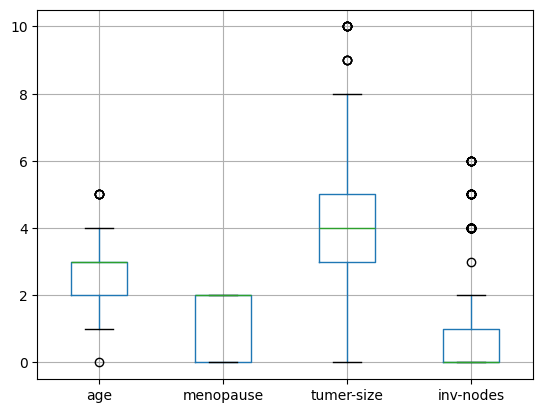

In [6]:
#data exploration part 2
X.boxplot()

In [7]:
from sklearn.preprocessing import OneHotEncoder #encoding nominal data
categorical_columns = ['breast', 'breast-quad', 'irradiate','node-caps']
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = enc.fit_transform(X[categorical_columns])
encoded_columns = enc.get_feature_names_out(categorical_columns)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_columns)
X = X.drop(categorical_columns, axis=1)
X = pd.concat([X, X_encoded_df], axis=1)
X.head(5)

,age,menopause,tumer-size,inv-nodes,deg-malig,breast_left,breast_right,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,irradiate_no,irradiate_yes,node-caps_no,node-caps_yes
0,2,2,2,0,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,3,0,2,0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,3,0,6,0,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2,2,6,0,3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2,2,5,4,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #splitting data into 80/20 train/test split

### Methods and Models

                  Feature  Importance
2              tumer-size    0.256584
0                     age    0.182074
4               deg-malig    0.125688
8    breast-quad_left_low    0.071370
1               menopause    0.065980
11   breast-quad_right_up    0.062414
3               inv-nodes    0.052009
9     breast-quad_left_up    0.044693
6            breast_right    0.036135
5             breast_left    0.032393
14           node-caps_no    0.017567
12           irradiate_no    0.015943
15          node-caps_yes    0.013994
13          irradiate_yes    0.013395
10  breast-quad_right_low    0.006991
7     breast-quad_central    0.002771
Train = 0.991228; Test = 0.637931
0.72 accuracy with a standard deviation of 0.05
0.68 precision with a standard deviation of 0.07
0.67 recall with a standard deviation of 0.05


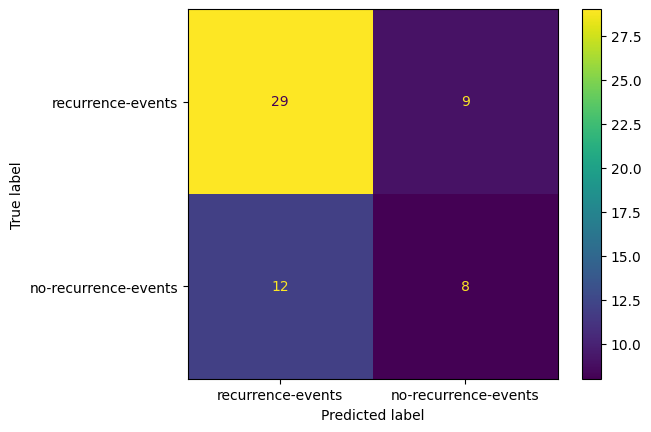

                  Feature  Importance
2              tumer-size    0.272702
4               deg-malig    0.150897
0                     age    0.145427
1               menopause    0.095614
8    breast-quad_left_low    0.061068
5             breast_left    0.050966
3               inv-nodes    0.041765
9     breast-quad_left_up    0.041268
15          node-caps_yes    0.031562
6            breast_right    0.031526
14           node-caps_no    0.018595
12           irradiate_no    0.016928
11   breast-quad_right_up    0.016323
13          irradiate_yes    0.014010
10  breast-quad_right_low    0.006961
7     breast-quad_central    0.004386
Train = 0.991228; Test = 0.741379
0.71 accuracy with a standard deviation of 0.05
0.68 precision with a standard deviation of 0.07
0.65 recall with a standard deviation of 0.08


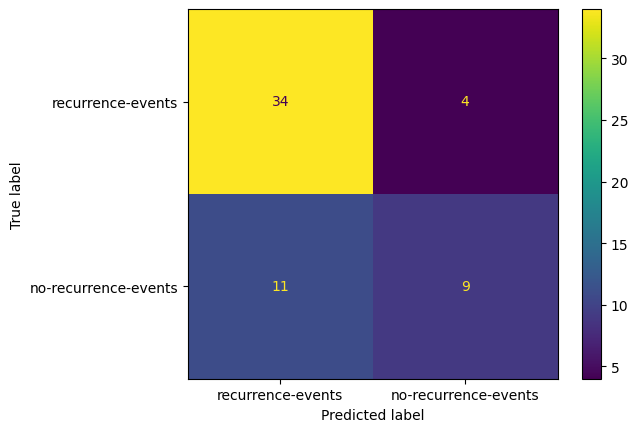

                  Feature  Importance
2              tumer-size    0.273798
4               deg-malig    0.145635
0                     age    0.142967
1               menopause    0.101168
8    breast-quad_left_low    0.064257
5             breast_left    0.052286
3               inv-nodes    0.043404
9     breast-quad_left_up    0.037729
6            breast_right    0.037223
15          node-caps_yes    0.035487
12           irradiate_no    0.015543
11   breast-quad_right_up    0.015025
14           node-caps_no    0.014662
13          irradiate_yes    0.009307
7     breast-quad_central    0.006238
10  breast-quad_right_low    0.005272
Train = 0.991228; Test = 0.724138
0.67 accuracy with a standard deviation of 0.07
0.67 precision with a standard deviation of 0.07
0.66 recall with a standard deviation of 0.06


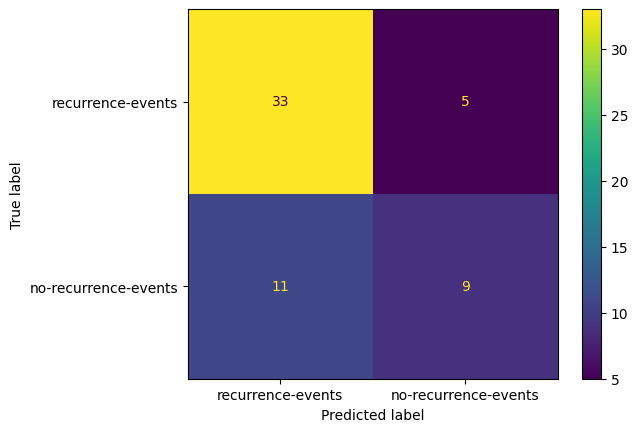

In [19]:
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PredictionErrorDisplay
import matplotlib.pyplot as plt
numBaseClassifiers = 100
maxdepth = 10
models = []
trainAcc = []
testAcc = []
i=0
featureNames = list(X_train.columns) #NEW AS OF 11/08/2024 -- stores the feature names

clf = ensemble.RandomForestClassifier(n_estimators=numBaseClassifiers) #random forest
models.append(clf)

clf = ensemble.BaggingClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers) #bagging classifier
models.append(clf)


clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers, algorithm='SAMME') #AdaBoost
models.append(clf)


for mod in models:
  clf.fit(X_train, Y_train)
  featureImportances = pd.DataFrame({
    'Feature': featureNames,
    'Importance': clf.feature_importances_
  }) #NEW AS OF 11/08/2024 -- dataframe to store importances and labels
  featureImportances = featureImportances.sort_values(by='Importance', ascending=False) #NEW AS OF 11/08/2024 -- sorts them in order of importance score
  print(featureImportances) #NEW AS OF 11/08/2024 -- prints them out
  Y_predTrain = clf.predict(X_train)
  Y_predTest = clf.predict(X_test)
  trainAcc.append(accuracy_score(Y_train, Y_predTrain))
  testAcc.append(accuracy_score(Y_test, Y_predTest))
  print('Train = %.6f; Test = %.6f'%(trainAcc[i],testAcc[i]))
  scores = cross_val_score(mod, X, Y, cv=10)
  print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
  scores1 = cross_val_score(clf, X, Y, cv = 10, scoring = 'precision_weighted')
  print("%0.2f precision with a standard deviation of %0.2f" % (scores1.mean(), scores1.std()))
  scores2 = cross_val_score(clf, X, Y, cv = 10, scoring = 'recall_weighted')
  print("%0.2f recall with a standard deviation of %0.2f" % (scores2.mean(), scores2.std()))
  cm = confusion_matrix(Y_test, Y_predTest)
  labels = ['recurrence-events', 'no-recurrence-events']
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot()
  plt.show()
  i+=1

### Conclusion
The objectives of this experiment are to utilize medical data regarding breast cancer to train multiple models to accurately predict whether those patients will have recurrence events or not over time. Data from from the University Medical Centre, Institute of Oncology, Ljubljana, Yugoslavia was used to train 3 models -- a random forest classifier, bagging classifier, and an adaboost classifier. The data was split into an 80/20 split of training to test data. All three models performed at around 67-73% accuracy given 10 fold cross-validation on the test data, and around 99% accuracy on the training data. This would be indicative of overfitting, given the disparity between accuracies of the test and training data. Attempts were made to remedy this error including an increase in the proportion of training data, but only marginal improvements were observed.

Of the models observed, Random forest classifier performed the best (73%), bagging classifier the second best (71%), and adaboost the worst (67%). Limitations on the data included a lack of additional data to add to the training set. While it was possible to expand the amount of training data by increasing the proportion, it was not possible to add more data other than those originally in the set used. Incorrectly labeled classes ranged from 15-17 depending on the model. One should note that these results were in line with results achieved with similar data from another medical center by Gupta, though this was in relation to recurrence time, not recurrence events alltogether [2].

For future work, it may be prudent to expand the dataset with data from other institutions that record similar metrics in breast cancer patients. This could take the form of a prolonged study in collaboration with multiple institutions to collect as much data as possible. That might improve accuracy and decrease overfitting. This may be necessary for the further improvement of prediction in this problem instance due to a general lack of recurrence data in breast cancer datasets [3]. Real world applications of these models might include the adjustment of treatment regimens when patients exhibit disease attributes that can be strongly associated with recurrence events, like the inclusion of preventative care and therapies.

**NEW AS OF 11/08/2024**
Consistently across all three models used, the top five features by importance are tumor size, degree of malignency, age, menopause, and breast-quad_left_low. Their importances occured in that order in two out of the three models, with random forest ranking age slightly higher than degree of malignancy. The ranking of the other features remains mostly consistent across all three models with small variations.

In conlcusion, this data mining exercise has real world potential to aid and help patients by identifying those with an increased risk of cancer recurrence events.



### References
[1] GeeksforGeeks, “Feature importance with random forests,” GeeksforGeeks, https://www.geeksforgeeks.org/feature-importance-with-random-forests/ (accessed Nov. 8, 2024). NEW -- reference for feature importance

[2] M. Zwitter and M. Soklic. "Breast Cancer," UCI Machine Learning Repository, 1988. [Online]. Available: https://doi.org/10.24432/C51P4M.

[3] Raj Gupta, Siddharth, "Prediction time of breast cancer tumor recurrence using Machine Learning," *Cancer Treatment and Research Communications*, Volume 32, 2022. Accessed Oct. 23, 2024. https://doi.org/10.1016/j.ctarc.2022.100602. [Online].

[4] P. H. Abreu, M. S. Santos, M. H. Abreu, B. Andrade, and D. C. Silva, "Predicting breast cancer recurrence using machine learning techniques: A systematic review," ACM Computing Surveys, vol. 49, no. 3, pp. 1–40, 2016.



In [20]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!pip install nbconvert
!cp "./drive/My Drive/Colab Notebooks/Midterm_Frizzell.ipynb" ./
!jupyter nbconvert --to PDF "Midterm_Frizzell.ipynb"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended texlive-pictures
  texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-fre